In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import norm,uniform,lognorm
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import pymc3 as pm3

ModuleNotFoundError: No module named 'pymc3'

If you have the same error "No module named 'pymc3'",
you can run the following command "!pip install pymc3"

In [2]:
!pip install pymc3

     |████████████████████████████████| 869 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 58.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 827 kB 44.6 MB/s eta 0:00:01
     |████████████████████████████████| 213 kB 25.2 MB/s eta 0:00:01
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529946 sha256=c1cf73e15ba17a5cdb120b614472ec3c3dab8e5d73e30097f2345b89dfbd8a20
  Stored in directory: /Users/aileen/Library/Caches/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [63]:
###Import it after installation
import pymc3 as pm3

##### Highest Posterior Density (HPD) Intervals
 

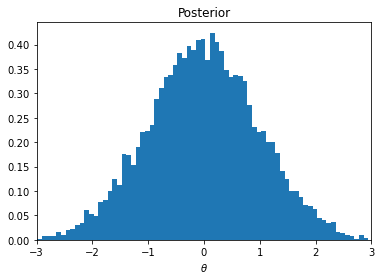

In [64]:
normal_chain = norm(0,1).rvs(10000)
ax = plt.hist(normal_chain,bins=100,density=True)
plt.xlabel('$\\theta$')
plt.xlim((-3,3))
plt.title('Posterior')
plt.show()

In [65]:
print("The mean is: ", normal_chain.mean())
print("The standard deviation is: ", normal_chain.std())
print("The median is: ", np.percentile(normal_chain,50))
print("The 95% Credible Interval (Equal-tail) is: ",np.percentile(normal_chain,[2.5,97.5]))

The mean is:  -0.00909683812995112
The standard deviation is:  0.9904446333609898
The median is:  -0.01581665089580469
The 95% Credible Interval (Equal-tail) is:  [-1.95258864  1.94628732]


In [66]:
print("The highest posterior density interval is: ")
print(pm3.stats.hdi(normal_chain, hdi_prob=.95))
hdint = pm3.stats.hdi(normal_chain, hdi_prob=.95)

The highest posterior density interval is: 
[-1.91055106  1.97816345]


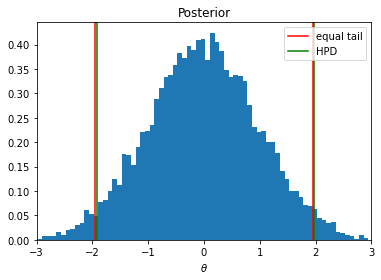

In [67]:
ax = plt.hist(normal_chain,bins=100,density=True)
plt.xlabel('$\\theta$')
plt.xlim((-3,3))
plt.title('Posterior')
plt.axvline(np.percentile(normal_chain,[2.5,97.5])[0],c='r',label='equal tail')
plt.axvline(np.percentile(normal_chain,[2.5,97.5])[1],c='r')
plt.axvline(hdint[0],c='g',label='HPD')
plt.axvline(hdint[1],c='g')
plt.legend()
plt.show()

### Bimodal Example

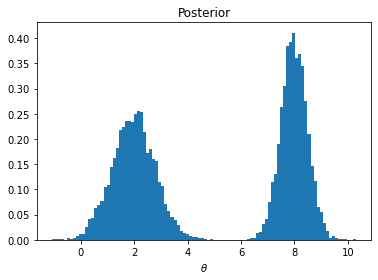

In [68]:
# suppose our chain was this
bimodal_chain = np.append(norm(2,.8).rvs(5000),norm(8,.5).rvs(5000))
plt.hist(bimodal_chain,bins=100,density=True)
plt.xlabel('$\\theta$')
plt.title('Posterior')
plt.show()

In [69]:
print("The highest posterior density interval is: ")
print(pm3.stats.hdi(bimodal_chain))
hdint = pm3.stats.hdi(bimodal_chain)

The highest posterior density interval is: 
[0.81727733 8.82658287]


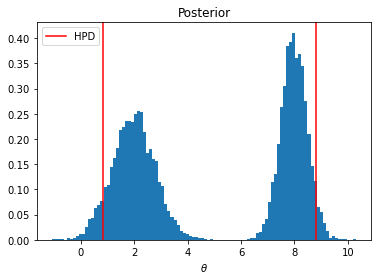

In [70]:
#Overlay the interval on top of your posterior
plt.hist(bimodal_chain,bins=100,density=True)
plt.xlabel('$\\theta$')
plt.title('Posterior')
plt.axvline(hdint[0],c='r',label='HPD')
plt.axvline(hdint[1],c='r')
plt.legend()
plt.show()

The pymc `stats.hdi` function is not built for multi-modal chains.

How to correct it?

In [71]:
#### Implement the search method
import numpy as np
import scipy.stats.kde as kde

def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
         x_hpd = x[(x > value[0]) & (x < value[1])]
         y_hpd = y[(x > value[0]) & (x < value[1])]
         modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [72]:
results = hpd_grid(bimodal_chain)
hpds = results[0]
print(hpds)

[(0.19, 3.75), (6.57, 9.4)]


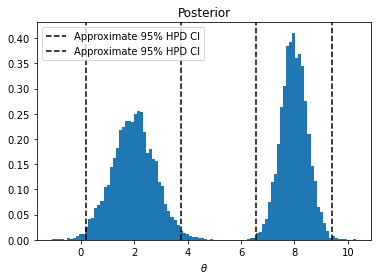

In [73]:
plt.hist(bimodal_chain,bins=100,density=True)
plt.xlabel('$\\theta$')
plt.title('Posterior')
for interval in hpds:
    plt.axvline(interval[0],c='k',linestyle='--',label="Approximate 95% HPD CI")
    plt.axvline(interval[1],c='k',linestyle='--')
plt.legend()
plt.show()

### Introduce PYMC3

Let's decribe a model.  Here, `mu` is defined as a stochastic variable (we want a chain of sampled values for this variable) and we provide a prior distribution and hyper-parameters for it.  The likelihood function is chosen to be Normal, with one parameter to be estimated (`mu`), and we use known $\sigma$ (denoted as `sigma`).  Our "dependent variable" is given by `observed=data`, where `data` is generated as follow and shown in the histogram.  In more formal terms, the code below sets up a `basic_model` having the following form:

\begin{align}
Prob(\mu|\sigma,\mathbf{data}) \propto& Prob(\mathbf{data}|\mu,\sigma) \times Prob(\mu | \mu^0_\mu, \sigma^0_\mu) \\
Prob(\mu|\sigma,\mathbf{data}) \propto& \phi \left( \frac{\mathbf{data} - \mu}{\sigma} \right ) \times \phi \left(\frac{\mu - \mu^0_\mu}{\sigma^0_\mu} \right ) \\
Prob(\mu|\sigma,\mathbf{data}) \propto& \phi \left( \frac{\mathbf{data} - \mu}{3} \right ) \times \phi \left(\frac{\mu - 8}{1.5} \right ) 
\end{align}
where $\phi(.)$ is the standard normal pdf. 

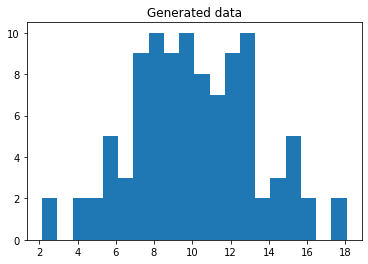

In [74]:
basic_model = pm3.Model()

sigma = 3 # Note this is the std of our data
data = norm(10,sigma).rvs(100)
mu_prior = 8
sigma_prior = 1.5  # Note this is our prior on the std of mu

plt.hist(data,bins=20)
plt.title("Generated data")
plt.show()

with pm3.Model() as basic_model:

    # Priors for unknown model parameters
    mu = pm3.Normal('Mean of Data',mu_prior,sigma_prior)
    
    # Likelihood (sampling distribution) of observations
    data_in = pm3.Normal('Y_obs', mu=mu, sd=sigma, observed=data)

We can numerically model the posterier distribution. (By using some sampling method, we will talk more about sampling later

In [75]:
chain_length = 10000 

with basic_model:
    # obtain starting values via MAP
    startvals = pm3.find_MAP(model=basic_model)
    print(startvals)
    # instantiate sampler
    step = pm3.Metropolis() 

    # draw 5000 posterior samples
    trace = pm3.sample(chain_length, step=step, start=startvals, return_inferencedata=True) 


{'Mean of Data': array(10.0376345)}


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [Mean of Data]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


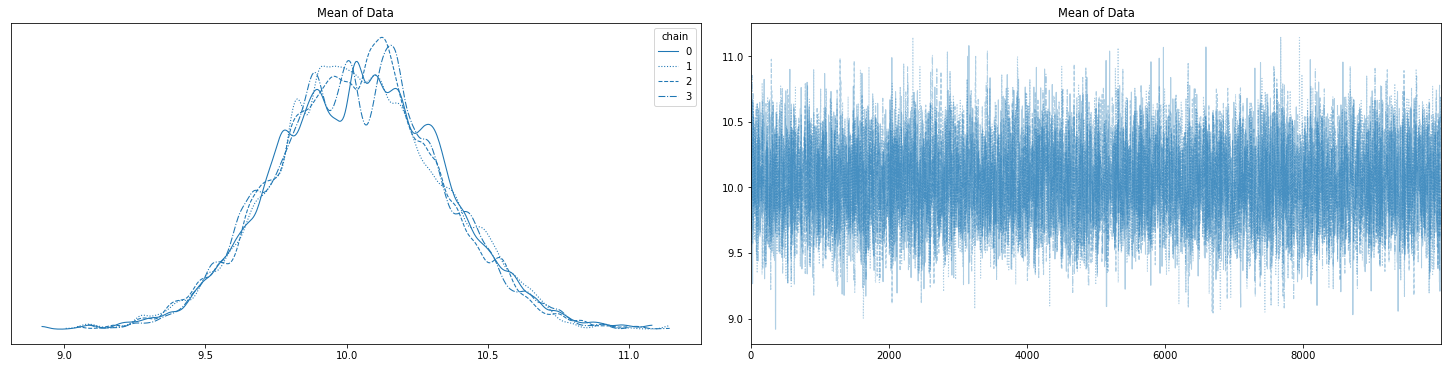

In [76]:
import arviz as az
az.plot_trace(trace,compact=True,figsize=(20,5),legend=True)
plt.show()


<AxesSubplot:title={'center':'Mean of Data'}>

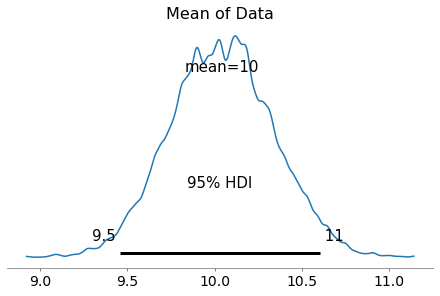

In [77]:
az.plot_posterior(trace,hdi_prob=0.95)

In [78]:
pm3.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Mean of Data,10.04,0.295,9.49,10.592,0.003,0.002,8610.0,8769.0,1.0
